In [11]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available! PyTorch can use the GPU.")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. PyTorch will use the CPU instead.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

CUDA is available! PyTorch can use the GPU.

Number of GPUs available: 1

Using GPU: NVIDIA GeForce RTX 4070 SUPER

Using device: cuda

In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import soundfile as sf

c:\Users\Angela\anaconda3\envs\capstone\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Angela\anaconda3\envs\capstone\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Angela\anaconda3\envs\capstone\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# File paths for the audio files and corresponding CSV annotations
audio_files = ['../data/Development_set/Development_Set/Training_Set/MT/dcase_MK1.wav', '../data/Development_set/Development_Set/Training_Set/MT/dcase_MK2.wav']
csv_files = ['../data/Development_set/Development_Set/Training_Set/MT/dcase_MK1.csv', '../data/Development_set/Development_Set/Training_Set/MT/dcase_MK2.csv']

# Output directory for AFE segments
# output_dir = 'processed_segments'
# os.makedirs(output_dir, exist_ok=True)

In [34]:
# Adapted from Esther's preprocessing code for audio segmentation from processed_segments.py
# Target sampling rate
sr = 8000

# Upsampling target rate
target_sr = 101640

# Initialize a dictionary to keep track of the number of segments for each label
label_count = {}

# Function to upsample audio segments
def upsample_audio(segment, initial_sr, target_sr):
    duration = len(segment) / initial_sr
    initial_time_points = np.linspace(0, duration, len(segment))
    target_time_points = np.linspace(0, duration, int(duration * target_sr))
    upsampled_segment = np.interp(target_time_points, initial_time_points, segment) # Perform linear interpolation to resample the original audio segment to the new time points
    return upsampled_segment

# Iterate through each audio file and its corresponding CSV annotation file
for audio_file, csv_file in zip(audio_files, csv_files):
    # Load the audio file
    y, sr = librosa.load(audio_file, sr=sr)

    # Load the CSV annotations
    annotations = pd.read_csv(csv_file)

    # Iterate over each row in the CSV to extract annotation details
    for i, annotation in annotations.iterrows():
        # Skip the segment if any of the annotation columns contain 'UNK'
        if 'UNK' in [annotation['SNMK'], annotation['CCMK'], annotation['AGGM'], annotation['SOCM']]:
            continue

        start_time = annotation['Starttime']
        end_time = annotation['Endtime']

        # Calculate the event center time
        event_center = (start_time + end_time) / 2

        # Calculate the segment start and end times to ensure a 1-second duration
        segment_start = max(0, event_center - 0.5)  # Ensure the start time is not negative
        segment_end = segment_start + 1.0  # End time is 1 second after the start time

        # Extract the segment from the audio file
        start_sample = int(segment_start * sr)
        end_sample = int(segment_end * sr)
        segment = y[start_sample:end_sample]

        # If the segment is less than 1 second, pad it with zeros
        if len(segment) < sr:
            segment = np.pad(segment, (0, sr - len(segment)), 'constant')
        
        # Upsample the segment to the target sampling rate
        upsampled_segment = upsample_audio(segment, initial_sr=sr, target_sr=target_sr)

        # Determine the label based on the annotation
        if annotation['SNMK'] == 'POS':
            label = 1  # SNMK
        elif annotation['CCMK'] == 'POS':
            label = 2  # CCMK
        elif annotation['AGGM'] == 'POS':
            label = 3  # AGGM
        elif annotation['SOCM'] == 'POS':
            label = 4  # SOCM
        else:
            label = 7  # unknown

        # Count the label
        label_count[label] = label_count.get(label, 0) + 1

        # Create the output filename based on the audio file name, label, and segment index
        output_filename = os.path.join(output_dir, f'{os.path.basename(audio_file).replace(".wav", "")}_segment_{i+1}_label_{label}.wav')

        # Save the segment as a WAV file using the soundfile library
        sf.write(output_filename, upsampled_segment, target_sr)

    # Process background noise segments
    no_event_segments = []
    for i in range(len(y) // sr):
        segment_start = i * sr
        segment_end = segment_start + sr
        segment = y[segment_start:segment_end]

        # Check if the segment overlaps with any event
        overlaps = any(start_sample <= segment_start <= end_sample or start_sample <= segment_end <= end_sample
                       for start_sample, end_sample in zip(annotations['Starttime'] * sr, annotations['Endtime'] * sr))

        if not overlaps:
            no_event_segments.append(segment)

    # Randomly select the same number of no-event segments as there are event segments
    np.random.shuffle(no_event_segments)
    selected_no_event_segments = no_event_segments[:len(annotations)]

    # Save the no-event segments with label 0 (background noise)
    for i, segment in enumerate(selected_no_event_segments):
        # Upsample background noise segments
        upsampled_segment = upsample_audio(segment, initial_sr=sr, target_sr=target_sr)
        output_filename = os.path.join(output_dir, f'segment_{os.path.basename(audio_file).replace(".wav", "")}_{i+1}_label_0.wav')
        sf.write(output_filename, upsampled_segment, target_sr)
        label_count[0] = label_count.get(0, 0) + 1

### Class Proportions Output:
- The output provides the count of segments for each label in the dataset, with labels corresponding to specific meerkat calls or noise.
- The output indicates that the 'Noise' (label 0) and 'CCMK' (label 2) classes are dominating the dataset, with a significantly higher number of segments compared to other classes like 'SNMK' (label 1), 'AGGM' (label 3), and 'SOCM' (label 4). This imbalance can skew the model's performance, as it may become biased towards the more frequent classes. 
- To address this issue, we can apply techniques such as resampling, either by oversampling the underrepresented classes or by selectively sampling the background noise to balance the number of samples per class. Additionally, applying class weighting during model training can help mitigate the effects of this imbalance.

In [5]:
label_names = {
    1: 'SNMK',  
    2: 'CCMK',  
    3: 'AGGM',  
    4: 'SOCM',  
    0: 'Noise',
    7: 'Unknown'  
}

# Display the count of segments per label
for label, count in label_count.items():
    label_name = label_names.get(label, 'Unknown')
    print(f'Label {label_name}: {count} segments')

NameError: name 'label_count' is not defined

In [3]:
# - Switch off warnings
import warnings

warnings.filterwarnings("ignore")

# - Import numpy
import numpy as np
import scipy as sp

# - Import the plotting library
import sys
!{sys.executable} -m pip install --quiet matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 10]
plt.rcParams["figure.dpi"] = 300

# - Rich printing
try:
    from rich import print
except:
    pass

In [4]:
# - import AFE
from rockpool.devices.xylo.syns61201 import AFESim

In [5]:
# - AFE parameters

fs = 1.0164e5                       # The sampling frequency of the input, in Hz
raster_period = 10e-3               # The output rasterisation time-step in seconds
max_spike_per_raster_period = 15    # Maximum number of events per output time-step

add_noise = False                    # Enables / disables simulated noise generated by the AFE
add_offset = False                 # Add mismatch offset to each filter
add_mismatch = False                 # Add simualted mismatch to filter parameters
seed = None                         # Seed for mistmatch generation

# - Initialize the AFE simulation, and convert it to a high-level `TimedModule`

afe = AFESim(
        fs = fs,
        raster_period = raster_period,
        max_spike_per_raster_period = max_spike_per_raster_period,
        add_noise = add_noise,
        add_offset = add_offset,
        add_mismatch = add_mismatch,
        seed = seed,
).timed()

In [6]:
from rockpool.timeseries import TSContinuous

# Load sample audio segment
audio_file_path = 'processed_segments/dcase_MK1_segment_177_label_3.wav'
segment, sr = librosa.load(audio_file_path, sr=fs)  

dt = 1 / fs
inp_ts = TSContinuous.from_clocked(segment, dt=dt, periodic=True, name="Audio Segment Input Sample 177")

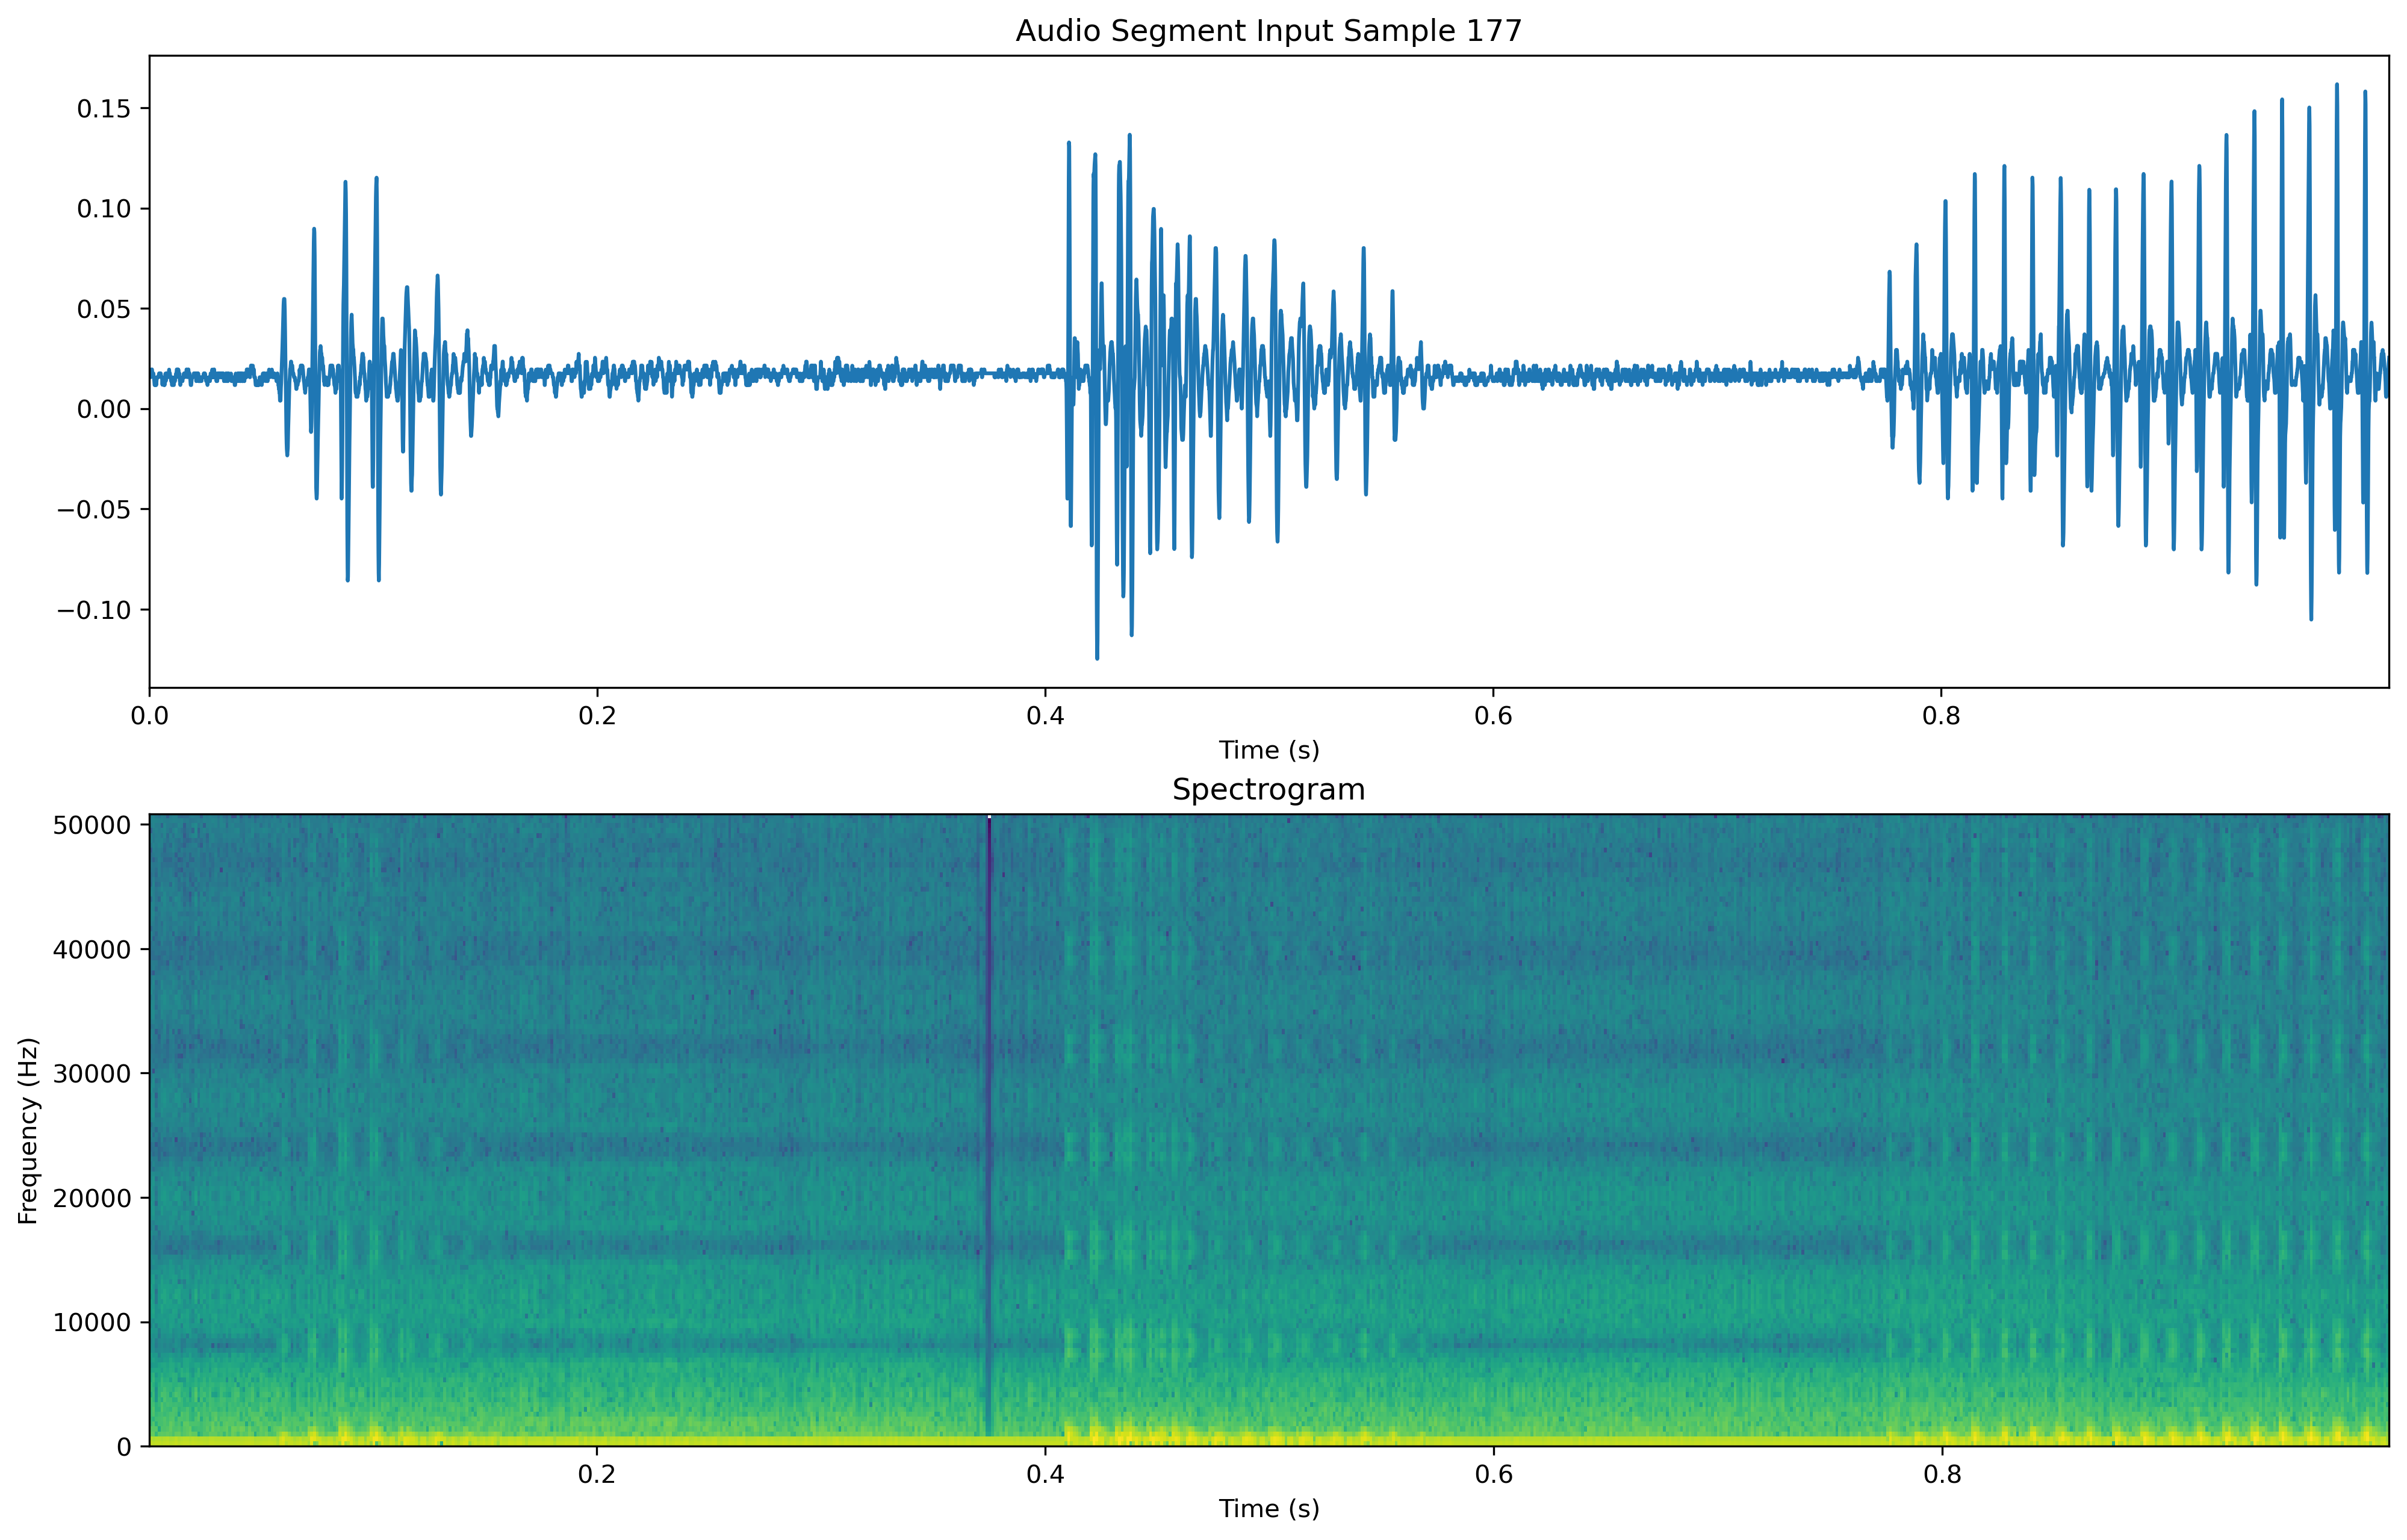

In [7]:
# Plot the input signal
fig = plt.figure()
ax = fig.add_subplot(211)
inp_ts.plot()

# Plot a spectrogram
ax = fig.add_subplot(212)
ax.specgram(segment, Fs=fs)
ax.set_ylim([0, fs/2])  
ax.set_ylabel("Frequency (Hz)")
ax.set_xlabel("Time (s)")
ax.set_title("Spectrogram");

In [8]:
# Process the sample audio segment through the AFESim
filt_spikes, state, rec = afe(inp_ts, record=True)

Text(0.5, 1.0, 'Spiking Output')

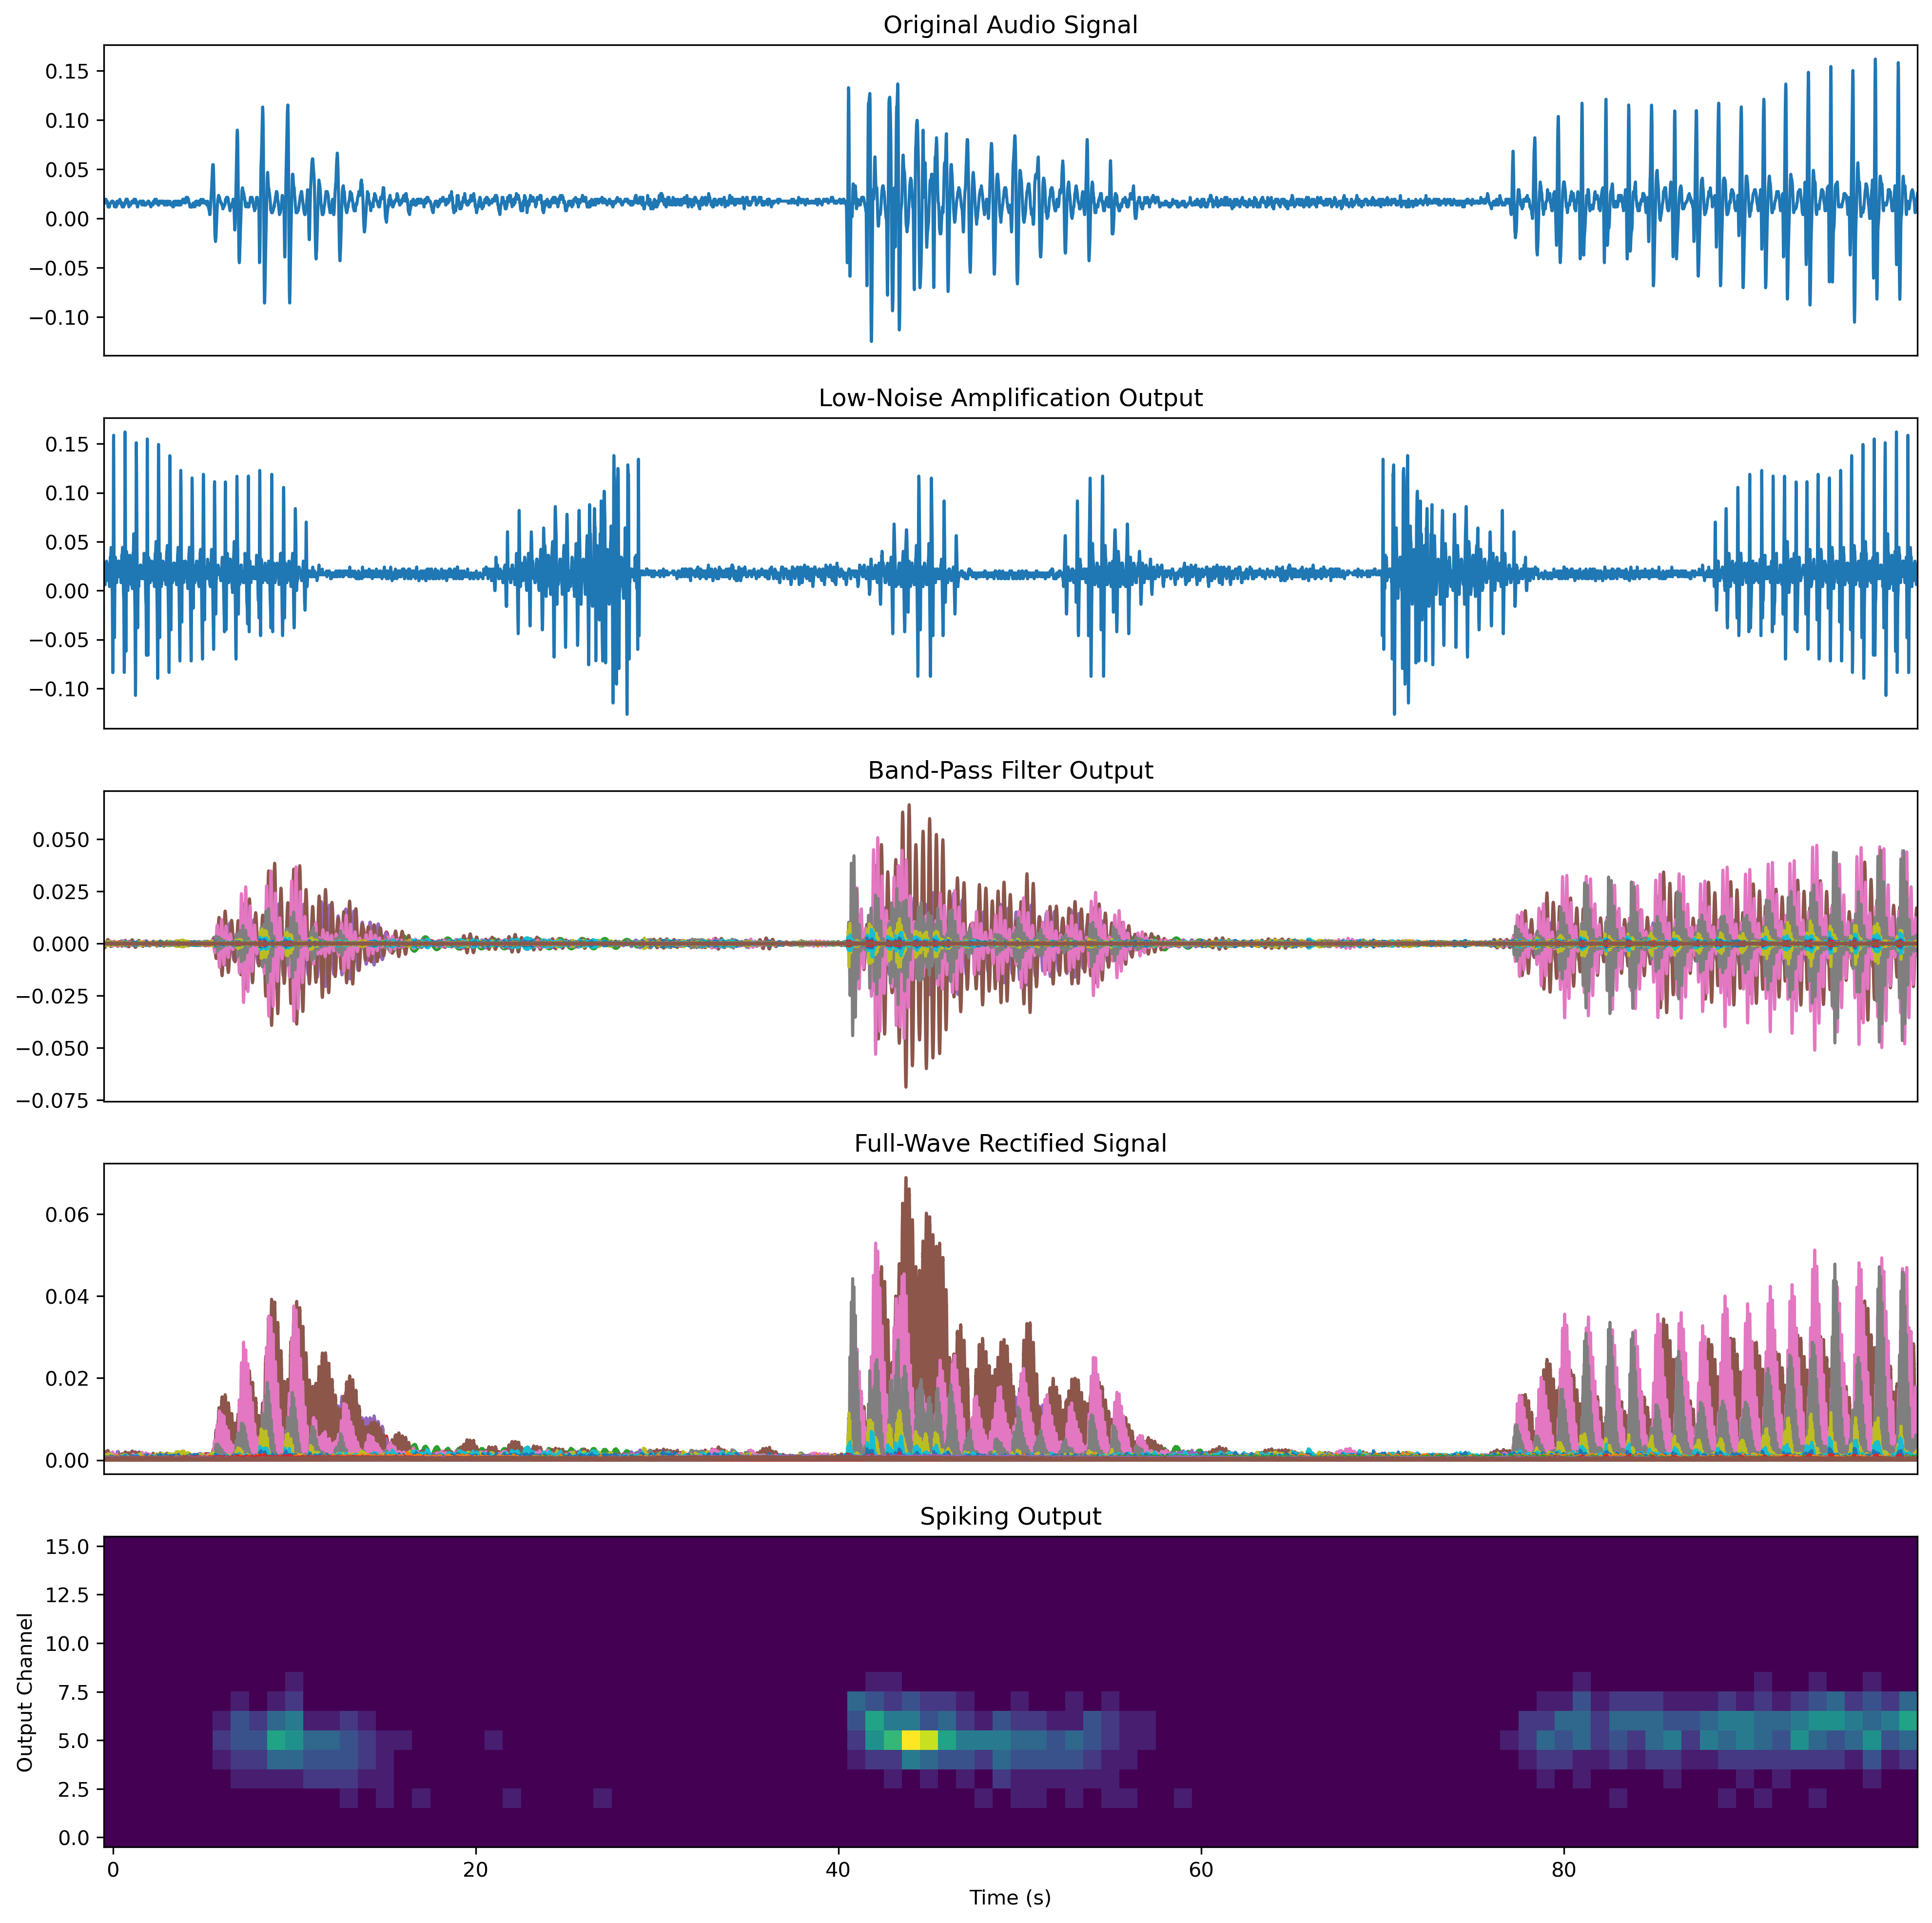

In [9]:
fig = plt.figure(figsize=(16, 16))

# Plot the original input signal
ax = fig.add_subplot(511)
inp_ts.plot()
ax.set_xticks([])
ax.set_xlabel("")
ax.set_title("Original Audio Signal")

# Plot the Low-Noise Amplifier (LNA) output
ax = fig.add_subplot(512)
rec["LNA_out"].plot()
ax.set_xticks([])
ax.set_xlabel("")
ax.set_title("Low-Noise Amplification Output")

# Plot the Band-Pass Filter (BPF) output
ax = fig.add_subplot(513)
rec["BPF"].plot()
ax.set_xticks([])
ax.set_xlabel("")
ax.set_title("Band-Pass Filter Output")

# Plot the Rectified Signal 
ax = fig.add_subplot(514)
rec["rect"].plot()
ax.set_xticks([])
ax.set_xlabel("")
ax.set_title("Full-Wave Rectified Signal")

# Plot the final spiking output
ax = fig.add_subplot(515)
plt.imshow(
    filt_spikes.raster(dt=10e-3, add_events=True).T, aspect="auto", origin="lower"
)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Output Channel")
ax.set_title("Spiking Output")


In [18]:
import torch
import os
import librosa
from tqdm import tqdm 

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Directory containing audio segments
audio_dir = 'processed_segments'

# Initialize lists to store audio segments and their corresponding labels
all_spikes = []
all_labels = []

# List of files in the directory
file_list = [filename for filename in os.listdir(audio_dir) if filename.endswith(".wav")]

max_length = 0

# Find max length of spike data
for filename in tqdm(file_list, desc="Finding max length", unit="file"):
    if filename.endswith(".wav"):
        audio_file_path = os.path.join(audio_dir, filename)
        segment, sr = librosa.load(audio_file_path, sr=fs)  
        dt = 1 / fs
        inp_ts = TSContinuous.from_clocked(segment, dt=dt, periodic=True)
        filt_spikes, state, rec = afe(inp_ts, record=True)

        spike_data = filt_spikes.raster(dt=10e-3, add_events=True).T
        max_length = max(max_length, spike_data.shape[1])



# Iterate through each audio file in processed_segments directory with a progress bar
for filename in tqdm(file_list, desc="Processing audio files", unit="file"):
    # Extract label from filename
    label = int(filename.split("_")[-1].replace(".wav", ""))

    audio_file_path = os.path.join(audio_dir, filename)
    segment, sr = librosa.load(audio_file_path, sr=fs)  
    dt = 1 / fs
    inp_ts = TSContinuous.from_clocked(segment, dt=dt, periodic=True)
    filt_spikes, state, rec = afe(inp_ts, record=True)

    # Convert spikes into numpy array
    spike_data = filt_spikes.raster(dt=10e-3, add_events=True).T

    # Pad spike data to match max length
    pad_width = max_length - spike_data.shape[1]
    spike_data = np.pad(spike_data, ((0, 0), (0, pad_width)), 'constant')
    
    # Convert to PyTorch tensor and move to GPU
    all_spikes.append(torch.tensor(spike_data, dtype=torch.float32).to(device))
    all_labels.append(label)

# Convert the list of tensors into a single tensor and move to GPU
all_spikes_tensor = torch.stack(all_spikes).to(device)
all_labels_tensor = torch.tensor(all_labels).to(device)

# Save tensors to disk
os.makedirs('tensors', exist_ok=True)
torch.save(all_spikes_tensor, 'tensors/spike_data_tensor.pt')
torch.save(all_labels_tensor, 'tensors/labels_tensor.pt')


Processing audio files: 100%|██████████| 2528/2528 [40:27<00:00,  1.04file/s]


In [15]:
all_spikes

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 tensor([[3., 2., 2.,  ..., 1., 1., 0.],
         [4., 3., 2.,  ..., 0., 2., 1.],
         [3., 3., 4.,  ..., 3., 2., 2.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 tensor([[3., 3., 1.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 2.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 1.],
         ...,
         [0., 0., 0.,  ...